In [1]:
import numpy as np
from scipy.constants import c, Boltzmann
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from scipy import signal

import pickle
import sympy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm

from scipy.sparse import csr_matrix
from joblib import Parallel, delayed

In [2]:
import os

parent_dir = os.path.dirname(os.getcwd())
print(parent_dir)  # Prints parent directory

os.chdir(parent_dir)
#print(os.getcwd())  # Prints current working directory

import mmars

c:\Users\malth\OneDrive - Aarhus Universitet\Dokumenter\AAU-Studie\10. semester\NEW GIT\MMARS


In [3]:
radar_model_1 = mmars.FmcwRadar(position=np.array([[0,0]]), signalNoiseRatio=[10, 10], N_chirps=1)

## Setting up the target

In [4]:
target_model_1 = mmars.Target(start_position=np.array([[10.001,10.001]]), start_velocity=1., T_total=100., T_frame=0.1)

target_model_1.generate_trajectory(trajectory_type="sinusoidal")

target_ground_truth = target_model_1.get_trajectory()

mrblatcomp = mmars.MRBLaT_Functions(radar_model_1, target_model_1)

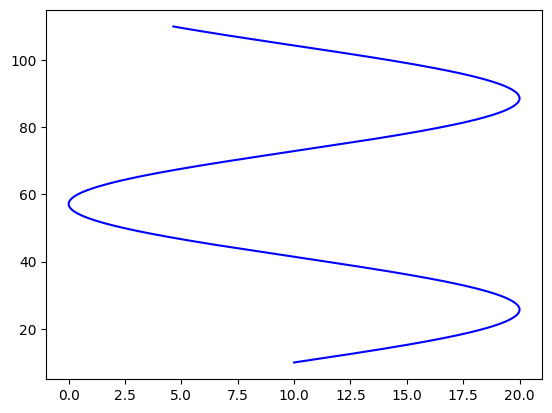

In [5]:
plt.plot(target_ground_truth[0], target_ground_truth[1], label="Ground Truth", color="blue")

In [6]:
simulation_data = mmars.MRBLaT_Functions(radar_model_1, target_model_1)

simulation_data.run()

Running simulation with <mmars.fmcwRadar.FmcwRadar object at 0x000001D356FC5CA0> and <mmars.target.Target object at 0x000001D356FC5430>


100%|██████████| 1000/1000 [00:00<00:00, 1099.90it/s]


In [7]:
sim_data = simulation_data.get_data()

In [272]:
frame = 250

print(target_model_1.get_trajectory()[0][frame], target_model_1.get_trajectory()[1][frame])

sim_data_all_virtual = sim_data[frame,:,:,0,:]
sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

max_range = 100
Ns = 3072


# Energy normalization
sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

data_fourier_energy = data_fourier.conj().T @ data_fourier

data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T

radar_model_1.generate_S_signal(target_model_1.get_trajectory()[0][frame], target_model_1.get_trajectory()[1][frame])

S_N = radar_model_1.get_S_signal.flatten()[:, np.newaxis]/np.sqrt(256)

15.985721441039365 35.001000000000246


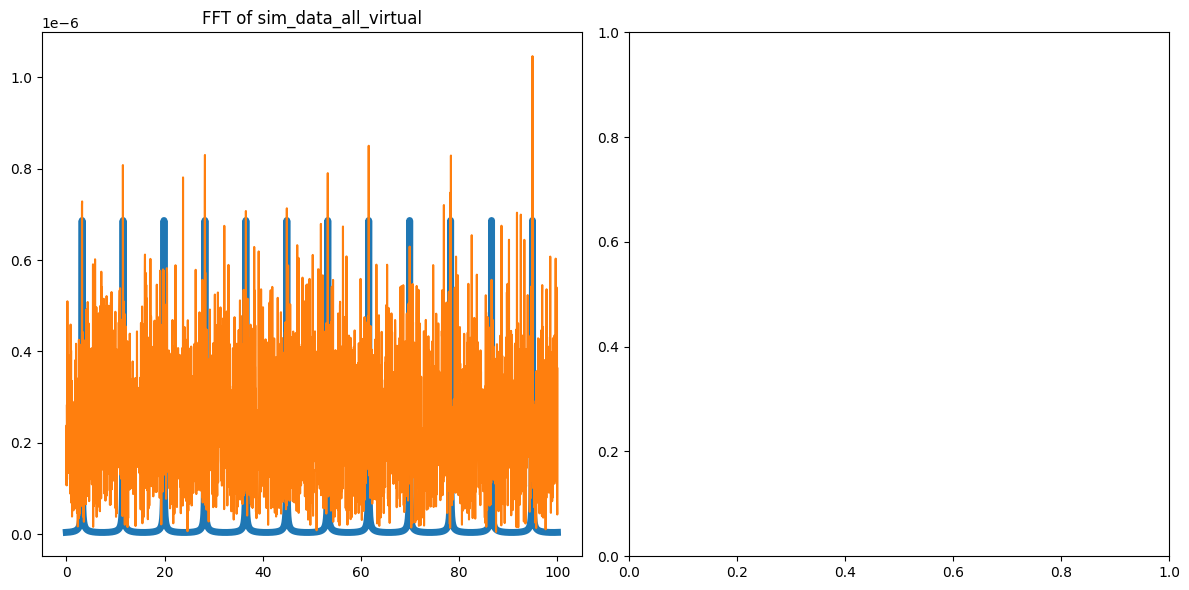

In [273]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))


#axs[0].plot(np.linspace(0, max_range, Ns), np.abs(data_fourier.T), lw=2)
axs[0].plot(np.linspace(0, max_range, Ns), np.abs(S_N), lw=5)
axs[0].plot(np.linspace(0, max_range, Ns), np.abs(data_fourier))

#axs[0].set_xlim([0, 10])
#axs[0].set_xlim([0, 10])
axs[0].set_title('FFT of sim_data_all_virtual')

#axs[1].set_xlim([0, 10])
#axs[1].set_title('Generated S Signal')

plt.tight_layout()
plt.show()

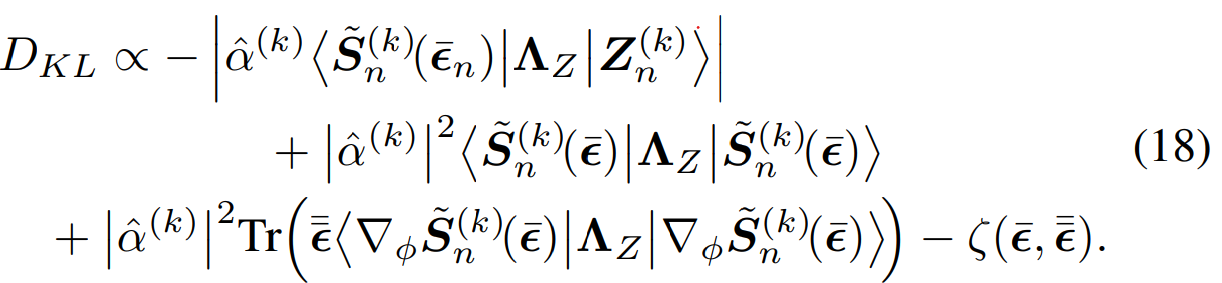

In [199]:
#Lambda_z = np.eye(3072) * (Boltzmann * 290 * 0.77e9)**(-2)
Lambda_z = np.eye(3072) * (radar_model_1.get_standardDeviation)**(-2)
Lambda_z = csr_matrix(Lambda_z)

In [200]:
sim_data_all_virtual = sim_data[frame,:,:,0,:]
sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

# Energy normalization
sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual
data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])
data_fourier_energy = data_fourier.conj().T @ data_fourier
data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T

In [203]:
last_frame_x = target_model_1.get_trajectory()[0][frame-1]
last_frame_y = target_model_1.get_trajectory()[1][frame-1]

param = (last_frame_x, last_frame_y, 5, 5)
bound = [(-100,100), (0.1,100), (0.01, 10), (0.01, 10)]

input = np.array([target_model_1.get_trajectory()[0][frame], target_model_1.get_trajectory()[1][frame], 0.5, 0.5])

result = minimize(mrblatcomp.D_KL, param, bounds = bound,  args=(data_fourier, last_frame_x, last_frame_y, (1,1,1,1), True), method='nelder-mead')
#mrblatcomp.D_KL(input, data_fourier, target_model_1.get_trajectory()[0][frame-1], target_model_1.get_trajectory()[0][frame-1], outputmode=(1,1,1,1), print_output=True)

[[-1830.88001068]] [[4419.69253945]] [[7500.98863806]] 4.447314978843446
[[-235.72495912]] [[3999.26375903]] [[6779.7961794]] 4.447314978843446
[[1431.23986802]] [[3999.26363035]] [[6787.18354133]] 4.447314978843446
[[-1830.88001068]] [[4419.69253945]] [[7658.9195075]] 4.471710060928162
[[-1830.88001068]] [[4419.69253945]] [[7718.10720053]] 4.471710060928162
[[1314.29622809]] [[4634.38364023]] [[8056.95776783]] 4.472007591433817
[[-3560.35626325]] [[4153.21599747]] [[7091.67831924]] 4.4535455285940815
[[154.72997344]] [[4728.4324256]] [[8260.10971094]] 4.475051733815045
[[-4741.53007816]] [[4172.11068348]] [[7126.34725526]] 4.45432162486897
[[-4259.7831174]] [[4163.5159348]] [[6981.52301751]] 4.440726425994487
[[-452.37383582]] [[4042.38305173]] [[6717.33991761]] 4.425775645169346
[[-4637.2073931]] [[4321.37935677]] [[7411.87296066]] 4.460509522612185
[[587.07376172]] [[3998.09515606]] [[6824.01925139]] 4.457319519709311
[[-4878.94348998]] [[4309.28306761]] [[7323.69629813]] 4.44989454

In [206]:
print(f"{result.x}\n{target_ground_truth[0][frame], target_ground_truth[1][frame]}")

[80.98145633 80.7455116   2.90926894  2.75780934]
(np.float64(10.20098666693333), np.float64(10.200999999999999))


In [205]:
result = differential_evolution(mrblatcomp.D_KL, bounds = bound,  args=(data_fourier, last_frame_x, last_frame_y, (1,1,1,1), False), strategy='best1bin', maxiter=1000, popsize=10, tol=0.001, mutation=(0.5, 1), recombination=0.7, seed=None, polish=True)

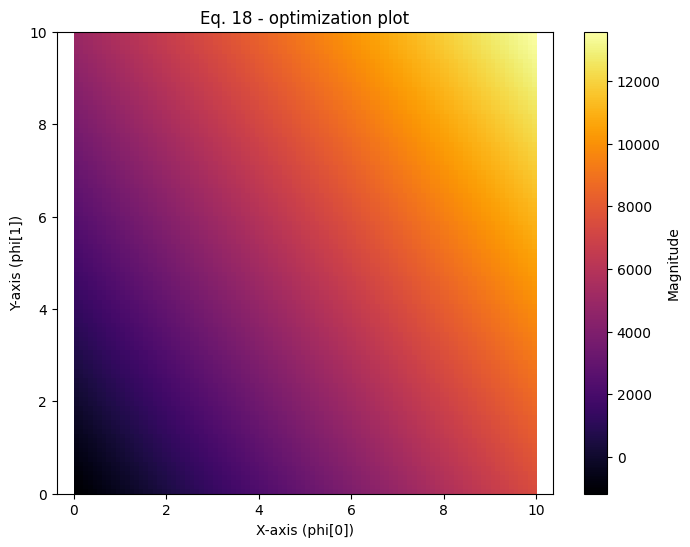

In [192]:
D_KL_search_space = np.linspace(0.01, 10, 100)

# Use parallel processing to speed up the nested loop
results = []
for i in D_KL_search_space:
    for j in D_KL_search_space:
        result = mrblatcomp.D_KL(np.array([10.08, 10.11, i, j]), data_fourier, target_model_1.get_trajectory()[0][frame-1], target_model_1.get_trajectory()[0][frame-1], outputmode=(1,1,1,1), print_output=False)
        results.append(result)

# Compute the magnitude (ignoring phi[2] and phi[3])
#magnitudes = np.sqrt(phis[:, 0, 0]**2 + phis[:, 1, 0]**2)

gridsize = 100

# Reshape to 2D (51x51) for heatmap plotting
heatmap = np.array(results).reshape(gridsize, gridsize)
# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(heatmap, origin='lower', extent=[0, 10, 0, 10], cmap='inferno', aspect='auto')
#min_index = np.argmin(heatmap)
#min_index_2d = np.unravel_index(min_index, heatmap.shape)
#plt.scatter(min_index_2d[1]/gridsize, min_index_2d[0]/gridsize, marker='x', color='red', s=100)
plt.colorbar(label="Magnitude")
plt.xlabel("X-axis (phi[0])")
plt.ylabel("Y-axis (phi[1])")
plt.title("Eq. 18 - optimization plot")
plt.axis('equal')
plt.show()

In [ ]:
min_index = np.argmin(heatmap)
min_index_2d = np.unravel_index(min_index, heatmap.shape)

print(f"Minimum value at index: {min_index_2d}")

np.min(heatmap)

Minimum value at index: (np.int64(0), np.int64(0))


np.float64(14025.543139649468)

In [210]:
gridsize = 100

# Define the range for phi[0] and phi[1]
x_values = np.linspace(0.0001, 50.0001, gridsize)  # 0 to 50 (inclusive)
y_values = np.linspace(0.0001, 50.0001, gridsize)

# Create a grid of all combinations of phi[0] and phi[1]

X, Y = np.meshgrid(x_values, y_values)

# Flatten the grid and stack with phi[2] = 0, phi[3] = 0
phis = [np.array([[x], [y], [1],  [1]]) for x, y in zip(X.ravel(), Y.ravel())]

# Convert to NumPy array (shape: (2500, 4, 1))
phis = np.array(phis)

print(f"Shape of phis: {phis.shape}")  # Expected: (2500, 4, 1)
#print(phis[:-2])  # Print first few vectors

Shape of phis: (10000, 4, 1)


In [214]:
S_signals = []
for n in tqdm(range(len(phis))):
    S_signals.append(mrblatcomp.D_KL(phis[n][:4].flatten(), data_fourier, target_model_1.get_trajectory()[0][frame-1], target_model_1.get_trajectory()[0][frame-1], outputmode=(1,1,1,1), print_output=False))

100%|██████████| 10000/10000 [00:17<00:00, 556.55it/s]


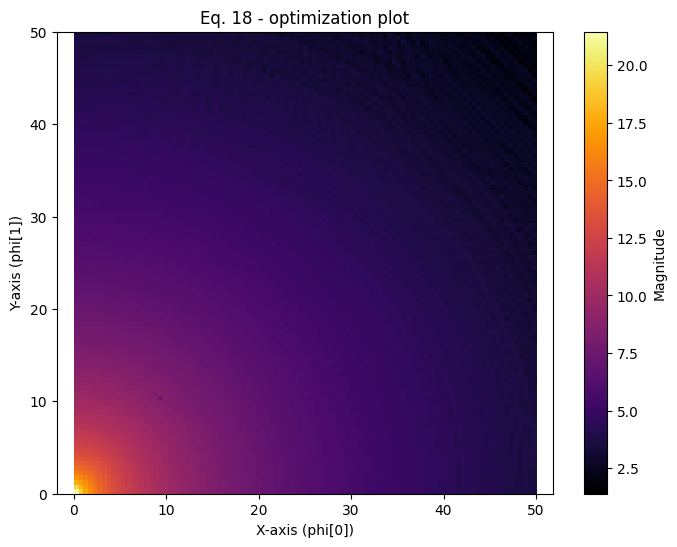

In [217]:
# Compute the magnitude (ignoring phi[2] and phi[3])
#magnitudes = np.sqrt(phis[:, 0, 0]**2 + phis[:, 1, 0]**2)

# Reshape to 2D (51x51) for heatmap plotting
heatmap = np.array(S_signals).reshape(gridsize, gridsize)

# Plot the heatmap
plt.figure(figsize=(8, 6))
plt.imshow(np.log(np.abs(heatmap[1:,1:])), origin='lower', extent=[0, 50, 0, 50], cmap='inferno')#, aspect='auto')
plt.colorbar(label="Magnitude")
plt.xlabel("X-axis (phi[0])")
plt.ylabel("Y-axis (phi[1])")
plt.title("Eq. 18 - optimization plot")
plt.axis('equal')
plt.show()

In [218]:
min_index = np.argmin(heatmap)
min_index_2d = np.unravel_index(min_index, heatmap.shape)
x_min = x_values[min_index_2d[1]]
y_min = y_values[min_index_2d[0]]

print(f"Minimum value at index: {min_index_2d}")
print(f"x: {x_min}, y: {y_min}")
np.min(heatmap)

Minimum value at index: (np.int64(99), np.int64(92))
x: 46.464746464646474, y: 50.0001


np.float64(3.996960170769479)

In [156]:
delta_t = 0.1

T = np.array([[1, 0, delta_t, 0],
            [0, 1, 0, delta_t],
            [0, 0, 1, 0],
            [0, 0, 0, 1]])

mu_a = np.array([[0],
                [0],
                [0],
                [0]])

G = np.diagflat([(delta_t**2)/2,(delta_t**2)/2,delta_t,delta_t])

G_inv = np.linalg.inv(G)

phi = np.array([[10],
                    [10],
                    [0],
                    [0]])

bound = [(-100,100), (0.1,100), (0.0001, 10), (0.0001, 10)]

In [286]:
def broadcast_parameters(n, phi_bar_last_x_, phi_bar_last_y_, phi_barbar_last_0_, phi_barbar_last_1_):
    """
    Each radar computes eps_bar and eps_barbar and broadcasts them.
    """
    # FOR LOOP HERE FOR MULTIPLE RADARS
    sim_data_all_virtual = sim_data[n,:,:,0,:].flatten()[:, np.newaxis]
    # Energy normalization
    sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

    data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

    data_fourier_energy = data_fourier.conj().T @ data_fourier

    data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T

    result = minimize(mrblatcomp.D_KL, (phi_bar_last_x_, phi_bar_last_y_, phi_barbar_last_0_, phi_barbar_last_1_), bounds = bound,  args=(data_fourier, phi_bar_last_x_, phi_bar_last_y_, (1,1,1,1), False), method='nelder-mead')
    
    return result.x[np.newaxis].T


def message_passing(N_iter = 100, N = 900):
    eps_bar_list = []
    eps_barbar_list = []

    phi_bar_list = [np.array([[target_ground_truth[0][0]], [target_ground_truth[1][0]], [target_ground_truth[2][0]], [target_ground_truth[3][0]]])]
    #print(phi_bar_list[0])
    phi_barbar_list = [np.array([[0.02,0,0,0], [0,0.02,0,0], [0,0,0.02,0], [0,0,0,0.02]])]

    # Define the shape and rate parameters for the Gamma prior
    zeta = 1
    chi = 1   

    # Number of dimensions
    dim = 4

    # Sample from Gamma distribution
    lambda_diag = np.random.gamma(shape=zeta/2, scale=2/chi, size=dim)

    # Create diagonal matrix
    Lambda_a = np.diag(lambda_diag)
    Lambda_a = np.eye((4))*0.05

    fifo = 1

    for n in tqdm(range(N)):
        D_KL_res = broadcast_parameters(n+1, phi_bar_list[n][0, 0], phi_bar_list[n][1, 0], phi_barbar_list[n][0, 0], phi_barbar_list[n][1, 1])
        eps_bar = D_KL_res[:2]
        eps_bar = np.vstack((eps_bar, np.array([[0.], [0.]])))
        eps_bar_list.append(eps_bar)
        eps_barbar_list.append(np.array([[D_KL_res[2][0],0,0,0], [0,D_KL_res[3][0],0,0], [0,0,0.01,0], [0,0,0,0.01]]))

        beta = np.zeros((4,4))
        

        for _ in range(N_iter):
            for i in range(len(phi_bar_list)-fifo, len(phi_bar_list)):
                if len(phi_bar_list) - i == 1:
                    phi_bar_bar_inv = np.linalg.inv(eps_barbar_list[i]) + G_inv.T@Lambda_a@G
                    phi_bar = np.linalg.inv(phi_bar_bar_inv) @ np.linalg.inv(eps_barbar_list[i]) @ eps_bar_list[i] + (G_inv.T@Lambda_a@G)@T@phi_bar_list[i]
                else:
                    phi_bar_bar_inv = np.linalg.inv(eps_barbar_list[i]) + G_inv.T@Lambda_a@G + T.T@G_inv.T@Lambda_a@G_inv@T
                    phi_bar = np.linalg.inv(phi_bar_bar_inv) @ np.linalg.inv(eps_barbar_list[i]) @ eps_bar_list[i] + (G_inv.T@Lambda_a@G)@T@phi_bar_list[i] + (T.T@G_inv.T@Lambda_a@G_inv@T)@np.linalg.inv(T)@phi_bar_list[i+1]
                if i >= 1:
                    alpha = i+1
                    beta += np.linalg.norm(np.linalg.inv(G)@(phi_bar-T@phi_bar_list[i]))**2 + G_inv@(np.linalg.inv(phi_bar_bar_inv)+T@phi_barbar_list[i]@T.T)@G_inv.T
                    Lambda_a = np.linalg.inv(beta/alpha)
        
        phi_bar_list.append(phi_bar)
        phi_barbar_list.append(np.linalg.inv(phi_bar_bar_inv))
        if fifo < 20:
            fifo += 1


    return phi_bar_list, phi_barbar_list

In [287]:
mrblat_data, mrblat_data_phibarbar= message_passing()

  0%|          | 1/900 [00:00<07:31,  1.99it/s]C:\Users\malth\AppData\Local\Temp\ipykernel_20600\3429561505.py:16: OptimizeWarning: Initial guess is not within the specified bounds
  result = minimize(mrblatcomp.D_KL, (phi_bar_last_x_, phi_bar_last_y_, phi_barbar_last_0_, phi_barbar_last_1_), bounds = bound,  args=(data_fourier, phi_bar_last_x_, phi_bar_last_y_, (1,1,1,1), False), method='nelder-mead')
100%|██████████| 900/900 [13:39<00:00,  1.10it/s]


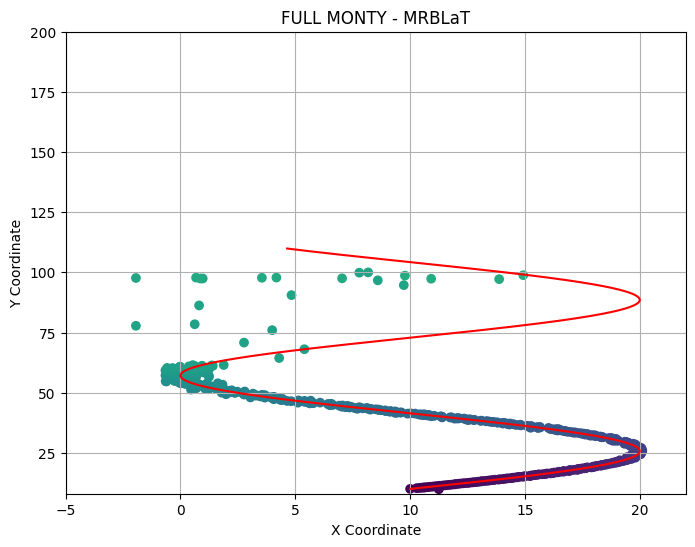

In [290]:
# Extract the first two indices from mrbalt_data
x_coords = [data[0, 0] for data in mrblat_data]
y_coords = [data[1, 0] for data in mrblat_data]

# Plot the coordinates
plt.figure(figsize=(8, 6))
plt.scatter(x_coords, y_coords,c=np.linspace(0, 1, len(x_coords)), cmap='viridis', marker='o')
plt.plot(target_ground_truth[0], target_ground_truth[1], c='red')
plt.xlim([-5, 22])
plt.ylim([8, 200])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('FULL MONTY - MRBLaT')
plt.grid(True)
plt.show()

In [271]:
mrblat_data_phibarbar

[array([[0.02, 0.  , 0.  , 0.  ],
        [0.  , 0.02, 0.  , 0.  ],
        [0.  , 0.  , 0.02, 0.  ],
        [0.  , 0.  , 0.  , 0.02]]),
 array([[0.009995, 0.      , 0.      , 0.      ],
        [0.      , 0.009995, 0.      , 0.      ],
        [0.      , 0.      , 0.009995, 0.      ],
        [0.      , 0.      , 0.      , 0.009995]]),
 array([[ 1.02259429e-02,  8.29994157e-16,  5.09605738e-08,
         -4.49834257e-12],
        [ 8.29994730e-16,  1.00762362e-02, -4.41676182e-12,
          5.05880726e-08],
        [ 1.27384715e-10,  5.43284018e-15,  9.99949224e-03,
          5.05246128e-07],
        [ 5.47253466e-15,  1.26453706e-10,  5.05246129e-07,
          9.99949222e-03]]),
 array([[ 2.08836122e+00,  6.20579554e-14,  1.00239433e-07,
         -6.90624723e-10],
        [ 6.18875427e-14,  9.99999874e-03, -1.74381808e-11,
          2.52016395e-08],
        [ 2.49913227e-10, -3.74972274e-14,  9.99974650e-03,
          2.53473407e-07],
        [-1.04119851e-12,  6.29980006e-11,  2.534

In [ ]:
results = np.zeros((1000, 4))

results[0] = np.array(([10, 10, 1, 1]))  # Initialize results as a list of lists

for n in tqdm(range(999)):

    sim_data_all_virtual = sim_data[n+1,:,:,0,:]
    sim_data_all_virtual = sim_data_all_virtual.flatten()[:, np.newaxis]

    # Energy normalization
    sim_data_all_virtual_energy = sim_data_all_virtual.conj().T @ sim_data_all_virtual

    data_fourier = np.concatenate([np.fft.fft(sim_data_all_virtual[i:i+256, 0]) for i in range(0, len(sim_data_all_virtual), 256)])

    data_fourier_energy = data_fourier.conj().T @ data_fourier

    data_fourier = (np.sqrt(sim_data_all_virtual_energy/data_fourier_energy)*data_fourier).T
    
    result = minimize(mrblatcomp.D_KL, (results[n][0], results[n][1], results[n][2], results[n][3]), bounds = bound,  args=(data_fourier, results[n][0], results[n][1], (1,1,1,1), False), method='nelder-mead')

    results[n+1] = result.x.tolist()  # Insert the result at the correct index

100%|██████████| 999/999 [08:42<00:00,  1.91it/s]


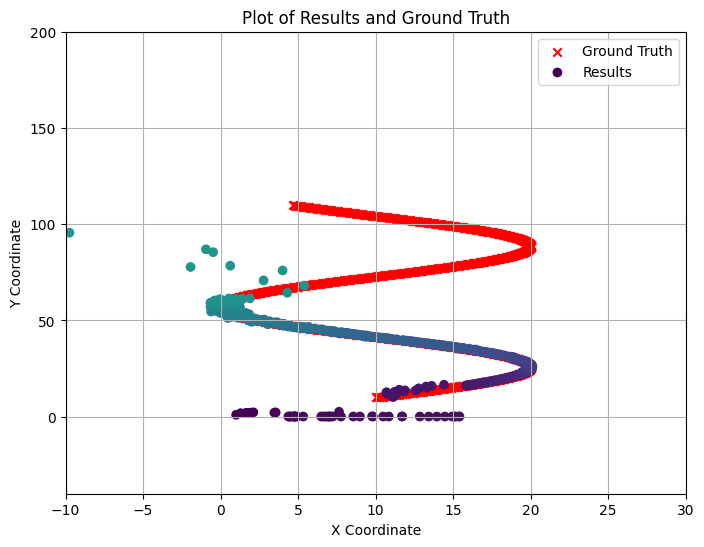

In [53]:
# Extract the first two indices from results
x_results = [result[0] for result in results]
y_results = [result[1] for result in results]

# Plot the coordinates
plt.figure(figsize=(8, 6))
plt.scatter(target_ground_truth[0], target_ground_truth[1], c='red', marker='x', label='Ground Truth')
plt.scatter(x_results, y_results, c=np.linspace(0, 1, len(x_results)), cmap='viridis', marker='o', label='Results')

#plt.scatter(eq18[0][0], eq18[1][0], c='green', marker='x', label='Eq. 18')
plt.xlim([-10, 30])
plt.ylim([-40, 200])
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('Plot of Results and Ground Truth')
plt.legend()
plt.grid(True)
plt.show()